### Známé chyby a TODO

- pro enigmu některé metriky nefungují, protože jsem tam přidala nan sloupce a řádky, přepsat
- pro domhofa jsou divné korelace s amplitudou, zjistit, proč to tak je
    - asi někde blbě filtruji, z čeho ty korelace počítám
- pro domhofa dodělat, aby fungovala i druhá parcelace

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, rankdata

import sys
sys.path.append('../')
from src import data

from netneurotools import metrics 
    # FIXME zjistit, proč tohle nefunguje přes pip
    # (mám to stažené lokálně z Githubu a to pak funguje)

%matplotlib widget

!date -I

2024-02-06


## Settings

In [2]:
FC_AVAILABLE = False
datasets_parcellations = {"enigma":["DKT"],"domhof":["DKT","Destrieux"],"rosen_halgren":["MNI-HCP-MMP1"]}

# set
PLOT=True
DATASET = "rosen_halgren"
PARCELLATION = "MNI-HCP-MMP1"
AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK = False


if DATASET not in datasets_parcellations.keys():
    print("Invalid dataset selection!")
elif PARCELLATION not in datasets_parcellations[DATASET]:
    print(f"Selected dataset {DATASET} not provided in {PARCELLATION} parcellation!")
    PARCELLATION == datasets_parcellations[DATASET][0]
    print(f"Parcellation set to {PARCELLATION}")
else: 
    print(f"Selected dataset {DATASET} and parcellation {PARCELLATION}.")

if DATASET == "domhof" and PARCELLATION == "Destrieux":
    print("FIXME: ROI selection needed, DOES NOT WORK")

Selected dataset domhof and parcellation DKT.


## Load data

### Load F-TRACT data

In [3]:
response_probability, response_amplitude, n_stim, n_impl, ftract_labels = data.load_ftract(PARCELLATION)

mask = np.logical_and(n_stim > 100, n_impl > 5)

if AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK:
    mask_amp = mask
else:
    mask_amp = (n_stim*response_probability)>100 # 100 significant responses FIXME opravdu to takhle jde?

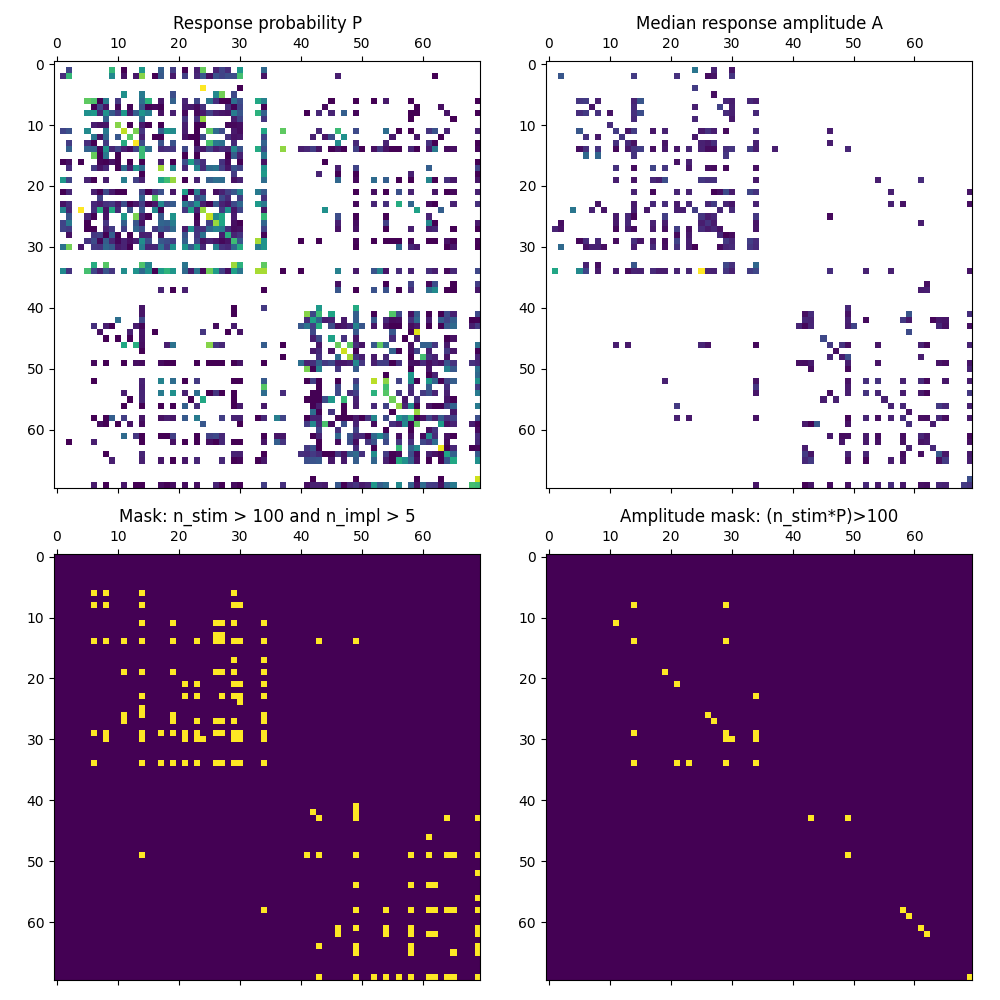

In [4]:
plt.rcParams['figure.figsize'] = [10, 10]

fig, axs = plt.subplots(2, 2, tight_layout=True)
axs[0,0].matshow(response_probability)
axs[0,0].set_title("Response probability P")
axs[0,1].matshow(response_amplitude)
axs[0,1].set_title("Median response amplitude A")
axs[1,0].matshow(mask)
axs[1,0].set_title("Mask: n_stim > 100 and n_impl > 5")
axs[1,1].matshow(mask_amp)

if AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK:
    axs[1,1].set_title("Amplitude mask same as mask")
else:
    axs[1,1].set_title("Amplitude mask: (n_stim*P)>100")

### Load structural (and functional) connectivity data

In [5]:
if DATASET == "enigma":
    SC_W, SC_L, FC = data.load_enigma(ftract_labels)

elif DATASET == "domhof":
    SC_W, SC_L, FC = data.load_domhof(PARCELLATION,len(ftract_labels))

elif DATASET == "rosen_halgren":
    SC_W, SC_L, FC = data.load_rosen_halgren(ftract_labels)

if FC is not None:
    FC_AVAILABLE = True

print(SC_W.shape)

(70, 70)


Text(0.5, 1.0, 'Structural connectivity - lengths (log)')

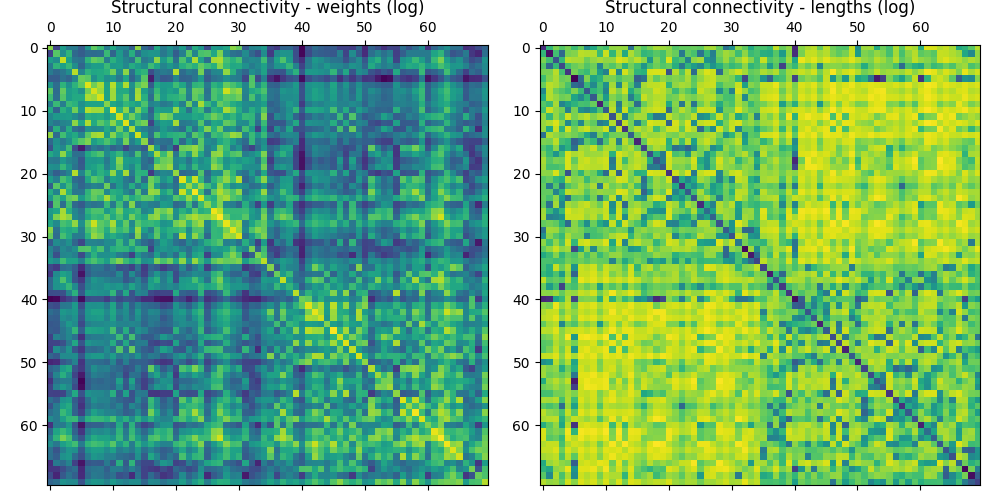

In [6]:
plt.rcParams['figure.figsize'] = [10, 5]

fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].matshow(np.log(SC_W))
axs[0].set_title("Structural connectivity - weights (log)")
axs[1].matshow(np.log(SC_L))
axs[1].set_title("Structural connectivity - lengths (log)")

Text(0.5, 1.0, 'ROI distances')

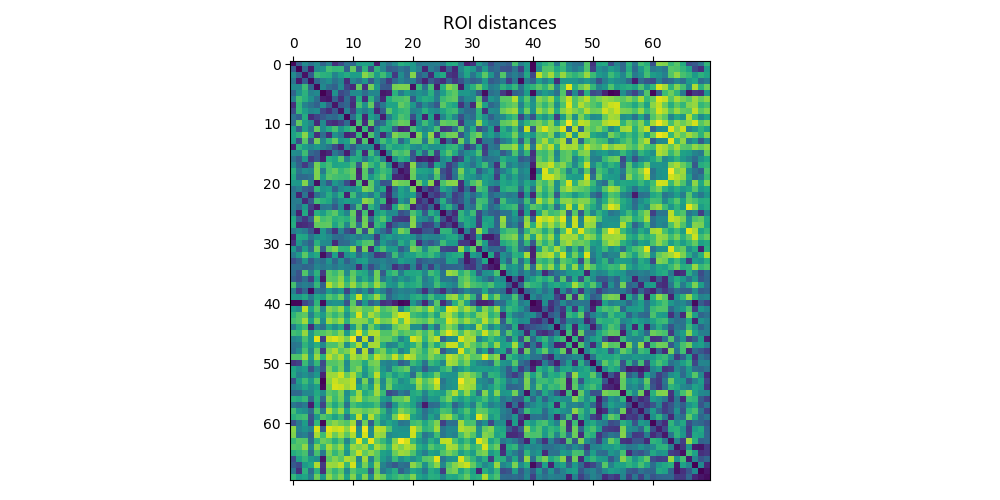

In [7]:
if PARCELLATION == "MNI-HCP-MMP1":
    ED = data.glasser_roi_distances(360,ftract_labels)
else:
    ED = SC_L

fig, axs = plt.subplots(1, 1, tight_layout=True)
axs.matshow(ED)
axs.set_title("ROI distances")

In [8]:
PLOT = False

## Correlations

In [9]:
# shortcut for correlation of X with response probability and amplitude 
rpf = response_probability[mask].flatten()
raf = response_amplitude[mask_amp].flatten()

def coor_with_response(X):
    r_probability = spearmanr(X[mask].flatten(),rpf,nan_policy='omit')
    r_amplitude = spearmanr(X[mask_amp].flatten(),raf,nan_policy='omit')

    print(f"Correlation with response probabilty: {r_probability.statistic:.3f} (p={r_probability.pvalue:.3f})")
    print(f"Correlation with response amplitude: {r_amplitude.statistic:.3f} (p={r_amplitude.pvalue:.3f})")

    if PLOT:
        coor_plot(X)

def coor_plot(X):
    rpf_ranks = rankdata(rpf[~np.isnan(rpf)], method='ordinal')
    X_ranks_rpf = rankdata(X.flatten()[~np.isnan(rpf)], method='ordinal')
    df_rpf = pd.DataFrame({'x':X_ranks_rpf,'y':rpf_ranks})
    sns.lmplot(data=df_rpf,x='x',y='y');

    raf_ranks = rankdata(raf[~np.isnan(raf)], method='ordinal')
    X_ranks_raf = rankdata(X.flatten()[~np.isnan(raf)], method='ordinal')
    df_raf = pd.DataFrame({'x':X_ranks_raf,'y':raf_ranks})
    sns.lmplot(data=df_raf,x='x',y='y');

In [10]:
coor_with_response(ED)

Correlation with response probabilty: -0.802 (p=0.000)
Correlation with response amplitude: -0.332 (p=0.079)


In [11]:
coor_with_response(SC_W) 

Correlation with response probabilty: 0.688 (p=0.000)
Correlation with response amplitude: 0.047 (p=0.810)


In [12]:
coor_with_response(SC_L) 

Correlation with response probabilty: -0.802 (p=0.000)
Correlation with response amplitude: -0.332 (p=0.079)


In [13]:
# shortest path efficiency
shorest_paths,_ = metrics.distance_wei_floyd(SC_L)
shorest_path_eff = np.divide(1,shorest_paths)

if PLOT:
    plt.matshow(shorest_path_eff)

coor_with_response(shorest_path_eff)

Correlation with response probabilty: 0.752 (p=0.000)
Correlation with response amplitude: 0.294 (p=0.122)


/tmp/ipykernel_56041/3541793006.py:3: RuntimeWarning: divide by zero encountered in divide
  shorest_path_eff = np.divide(1,shorest_paths)


In [14]:
com = metrics.communicability_wei(SC_W)
coor_with_response(com)

Correlation with response probabilty: 0.234 (p=0.003)
Correlation with response amplitude: -0.243 (p=0.204)


In [15]:
SI = metrics.search_information(SC_W,ED) # má tu být ED?

if PLOT:
    plt.matshow(SI)

coor_with_response(SI)

Correlation with response probabilty: -0.667 (p=0.000)
Correlation with response amplitude: 0.011 (p=0.972)


In [16]:
# https://netneurolab.github.io/netneurotools/_modules/netneurotools/metrics.html#diffusion_efficiency
diffusion = metrics.diffusion_efficiency(SC_W)[1] # tahle funkce určitě má dostat SC, a ne délky L

if PLOT:
    plt.matshow(diffusion)

coor_with_response(diffusion)

Correlation with response probabilty: -0.167 (p=0.036)
Correlation with response amplitude: -0.299 (p=0.116)


/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:780: RuntimeWarning: divide by zero encountered in divide
  E_diff = np.divide(1, mfpt)


In [17]:
# tady té funkci možná dávám špatný vstup?
_,_,nav_paths,_,_ = metrics.navigation_wu(SC_L, SC_W)
nav_eff = np.divide(1,nav_paths)

if PLOT:
    plt.matshow(nav_eff)

coor_with_response(nav_eff)

Correlation with response probabilty: 0.700 (p=0.000)
Correlation with response amplitude: 0.294 (p=0.122)


/tmp/ipykernel_56041/3036424556.py:3: RuntimeWarning: divide by zero encountered in divide
  nav_eff = np.divide(1,nav_paths)
